<a href="https://colab.research.google.com/github/linadrozd/ai_banana/blob/main/banana_epoch5_batch_8_inc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.utils import make_grid
from google.colab import files 
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/Ai'
!ls {PATH_OF_DATA}

banana_14_04_epoch5.pt	banana_test  banana_train


In [5]:
torch.manual_seed(42)
dataset = ImageFolder(root="/content/gdrive/My Drive/Ai/banana_train", transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))
dataset_size = len(dataset)
dataset_size
classes = dataset.classes
classes
num_classes = len(dataset.classes)
num_classes
test_size = round(dataset_size*0.10)
nontest_size = len(dataset) - test_size
nontest_ds, test_ds = random_split(dataset, [nontest_size, test_size])
len(nontest_ds), len(test_ds)
val_size = round(dataset_size*0.10)
train_size = len(nontest_ds) - val_size
train_ds, val_ds = random_split(nontest_ds, [train_size, val_size])
len(train_ds), len(val_ds)
batch_size = 8

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
nn.Flatten(), 
            nn.Linear(256*16*16 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)
model = CnnModel()

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
def __len__(self):
        """Number of batches"""
        return len(self.dl)
       
device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
model = to_device(CnnModel(), device)
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break
num_epochs1 = 6
num_epochs2 = 6
num_epochs3 = 6
opt_func = torch.optim.Adam
lr1 = 0.000010
lr2 = 0.0000005
lr3 = 0.0000001


images.shape: torch.Size([8, 3, 256, 256])
out.shape: torch.Size([8, 10])
out[0]: tensor([ 0.0187, -0.0275, -0.0411, -0.0187, -0.0431, -0.0312, -0.0402, -0.0288,
         0.0330, -0.0119], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
evaluate(model, val_dl)
history1 = fit(num_epochs1, lr1, model, train_dl, val_dl, opt_func)
history2 = fit(num_epochs1, lr2, model, train_dl, val_dl, opt_func)
history3 = fit(num_epochs1, lr3, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6056, val_loss: 0.0571, val_acc: 0.9818
Epoch [1], train_loss: 0.0704, val_loss: 0.0376, val_acc: 0.9844
Epoch [2], train_loss: 0.0477, val_loss: 0.0167, val_acc: 0.9896
Epoch [3], train_loss: 0.0378, val_loss: 0.0140, val_acc: 0.9948
Epoch [4], train_loss: 0.0342, val_loss: 0.0400, val_acc: 0.9818
Epoch [5], train_loss: 0.0277, val_loss: 0.0084, val_acc: 0.9974
Epoch [0], train_loss: 0.0188, val_loss: 0.0085, val_acc: 0.9974
Epoch [1], train_loss: 0.0181, val_loss: 0.0103, val_acc: 0.9974
Epoch [2], train_loss: 0.0176, val_loss: 0.0118, val_acc: 0.9948
Epoch [3], train_loss: 0.0174, val_loss: 0.0098, val_acc: 0.9974
Epoch [4], train_loss: 0.0168, val_loss: 0.0108, val_acc: 0.9948
Epoch [5], train_loss: 0.0162, val_loss: 0.0107, val_acc: 0.9948
Epoch [0], train_loss: 0.0158, val_loss: 0.0092, val_acc: 0.9974
Epoch [1], train_loss: 0.0157, val_loss: 0.0088, val_acc: 0.9974


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Epoches vs Accuracy ');
plot_accuracies(history1)
plot_accuracies(history2)
plot_accuracies(history2)

In [ ]:
predicted_classes = torch.argmax(out, dim=1) == 0
target_classes = self.get_vector(y_batch)
target_true += torch.sum(target_classes == 0).float()
predicted_true += torch.sum(predicted_classes).float()
correct_true += torch.sum(
    predicted_classes == target_classes * predicted_classes == 0).float()

Text(0, 0.5, 'Accuracy')

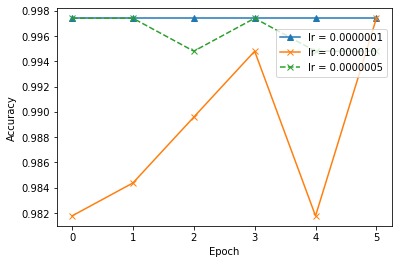

In [12]:
accuracies1 = [x['val_acc'] for x in history1]
accuracies2 = [x['val_acc'] for x in history2]
accuracies3 = [x['val_acc'] for x in history3]
plt.plot(accuracies3, "-^",label = 'lr = 0.0000001')
plt.plot(accuracies1, '-x', label = 'lr = 0.000010') 
plt.plot(accuracies2, '--x', label = 'lr = 0.0000005')
plt.legend(loc='upper right', bbox_to_anchor=(1,0.93))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')



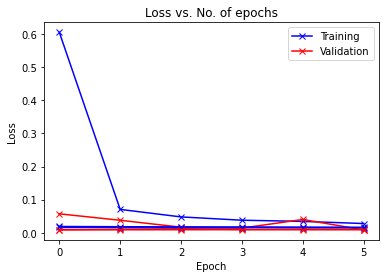

In [13]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history1)
plot_losses(history2)
plot_losses(history3)

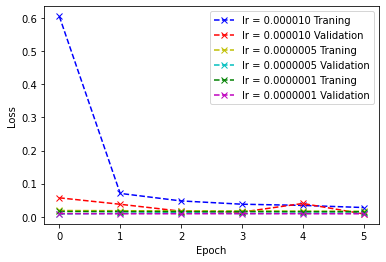

In [14]:
    train_losses1 = [x.get('train_loss') for x in history1]
    val_losses1 = [x['val_loss'] for x in history1]
    plt.plot(train_losses1, '--bx', label = 'lr = 0.000010 Traning')
    plt.plot(val_losses1, '--rx', label = 'lr = 0.000010 Validation')
    train_losses2 = [x.get('train_loss') for x in history2]
    val_losses2 = [x['val_loss'] for x in history2]
    plt.plot(train_losses2, '--yx', label = 'lr = 0.0000005 Traning')
    plt.plot(val_losses2, '--cx', label = 'lr = 0.0000005 Validation')
    train_losses3 = [x.get('train_loss') for x in history3]
    val_losses3 = [x['val_loss'] for x in history3]
    plt.plot(train_losses3, '--gx', label = 'lr = 0.0000001 Traning')
    plt.plot(val_losses3, '--mx', label = 'lr = 0.0000001 Validation')



    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


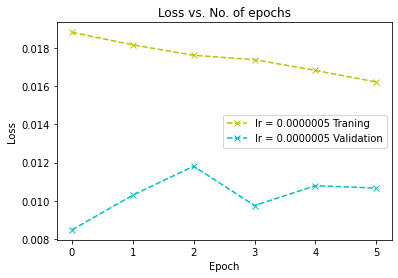

In [15]:
    train_losses2 = [x.get('train_loss') for x in history2]
    val_losses2 = [x['val_loss'] for x in history2]
    plt.plot(train_losses2, '--yx', label = 'lr = 0.0000005 Traning')
    plt.plot(val_losses2, '--cx', label = 'lr = 0.0000005 Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs');

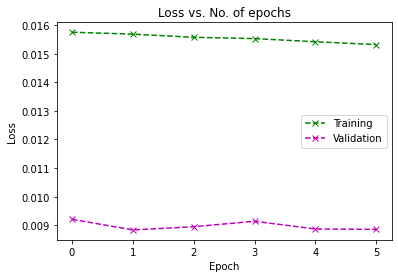

In [16]:
    train_losses3 = [x.get('train_loss') for x in history3]
    val_losses3 = [x['val_loss'] for x in history3]
    plt.plot(train_losses3, '--gx')
    plt.plot(val_losses3, '--mx')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

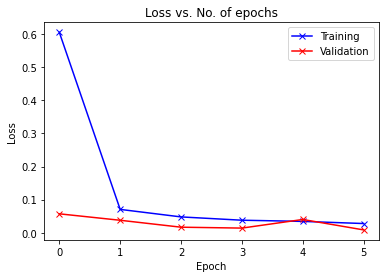

In [17]:
    train_losses1 = [x.get('train_loss') for x in history1]
    val_losses1 = [x['val_loss'] for x in history1]
    plt.plot(train_losses1, '-bx')
    plt.plot(val_losses1, '-rx')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [19]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:

    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 0/1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1, precision, recall, tp, fn, fp, y_pred, y_true

In [20]:
f1_loss(labels,out)


(tensor(0.9412, device='cuda:0'),
 tensor(0.5000, device='cuda:0'),
 tensor(8., device='cuda:0'),
 tensor(32., device='cuda:0'),
 tensor(-28., device='cuda:0'),
 tensor(32., device='cuda:0'),
 tensor([8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0'),
 tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0'))

In [22]:
d= {'Training Loss1':train_losses1, 'Validation Loss1':val_losses1, 'Accuracy1':accuracies1, 'Training Loss2':train_losses2, 'Validation Loss2':val_losses2, 'Accuracy2':accuracies2, 'Training Loss':train_losses1, 'Validation Loss3':val_losses3, 'Accuracy3':accuracies3}
df= pd.DataFrame(d)
df.to_csv('evalution1.csv')
files.download('evalution1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
model_save_name = 'banana_14_04_epoch5.pt'
PATH = F"/content/gdrive/My Drive/Ai/{model_save_name}" 

torch.save(model.state_dict(), PATH)

In [ ]:
model = CnnModel()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

In [ ]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1

In [ ]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)